# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT
env=Chess_Env(size_board)

In [3]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 3 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 1 0]]
check?  0
dofk2  1

[[0 0 0 3]
 [0 0 0 0]
 [2 0 0 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  2

[[0 0 0 3]
 [0 0 0 0]
 [2 0 0 1]
 [0 0 0 0]]
0.0  1
check?  0
dofk2  0


In [3]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]
        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.193 Number of steps:  7.236


In [3]:
# Define Qvalues function
def Qvalues(x, W1, W2, b1,b2):
    # Result of the hidden layer
    h = np.dot(x,W1) + b1
    # Result of the neural network
    y= np.dot(h,W2)+b2
    # Return the results through RELU activation function 
    return np.maximum(y,0), np.maximum(h,0)

# Define Epsilon Greedy Policy taking the Q as Qvalues, epsilon and possible actions
def EpsilonGreedy_Policy(Q, epsilon, allowed_a, seed):
    np.random.seed(seed)
    # Get index of valid actions
    validActions= np.where(allowed_a==1)[0]
    # Random value for taking a random action
    rand_value= np.random.uniform(0,1)
    rand_a = rand_value<epsilon
    if rand_a==True:
        # Random action where the action is legal
        a= np.random.choice(validActions)
    else:
        # Legal action with the highest Q values
        # Get all valid Q_values 
        valid_Q = Q[validActions]
        # Get maximum
        max_Q_value = np.max(valid_Q)
        # Return the valid actions with highest Q values
        a = np.where(Q==max_Q_value)[0][0]
    return a

In [11]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

# Initialize Neural Network
np.random.seed(0)
W1 = np.random.uniform(-1,1,[N_in, N_h])/(N_in+N_h)
b1 = np.zeros([N_h])
W2 = np.random.uniform(-1,1,[N_h,N_a])/(N_in+N_h)
b2 = np.zeros([N_a])

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
beta_1 = 0.00003    # BETA FOR LESS DECAYING RATE
gamma = 0.85        # THE DISCOUNT FACTOR
gamma_1 = 0.9       # LOWER DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
beta_A = 0.9        # First order momentum for Adam

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


TASK 3: TRAIN AGENT USING SARSA

In [ ]:
# Prepare parameter for Sarsa
W1_S = np.copy(W1)
W2_S = np.copy(W2)
b1_S = np.copy(b1)
b2_S = np.copy(b2)
R_save_S  = np.copy(R_save)
N_moves_save_S = np.copy(N_moves_save)

# Reset the seed = 1 to get the exact same result
seed = 1
# TRAINING LOOP FOR SARSA
for n in range(N_episodes):
    # Calculate decaying Epsilon
    epsilon_f = epsilon_0 / (1 + beta * n)  
    Done=0  
    # Counter for the number of actions made                                 
    i = 1        
    # Initalize the game                            
    S,X,allowed_a=env.Initialise_game()     
    # Calculate Q values and activation result of hidden layer
    Q,x1 = Qvalues(X, W1_S, W2_S, b1_S, b2_S)        
    # Chose the action based on Q value, epsilon and the allowed actions
    seed +=1
    a_agent = EpsilonGreedy_Policy(Q,epsilon_f,allowed_a,seed)
    while Done==0:                           ## START THE EPISODE
        # Tale the action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        # If finished, parameters without the decaying factor for future Q value (because there is no next step)
        if Done==1:
            delta=R-Q[a_agent]

            delta_b2 = delta
            delta_W2=delta*x1
            delta_b1 = delta*W2_S[:,a_agent]*(x1>0)
            delta_W1=np.outer(X,delta_b1)

            # Updating Weights and Biases through back propagation
            W2_S[:,a_agent]=W2_S[:,a_agent]+eta*delta_W2
            b2_S[a_agent]=b2_S[a_agent]+eta*delta_b2
            W1_S=W1_S+eta*delta_W1
            b1_S=b1_S+eta*delta_b1
            
            R_save_S[n]=np.copy(R)
            N_moves_save_S[n]=np.copy(i)
            break

        # Calculate next Q values
        Q_next,_ = Qvalues(X_next,W1_S,W2_S,b1_S,b2_S) 
        seed +=1
        # Chose next action based on policy
        a_agent_next = EpsilonGreedy_Policy(Q_next, epsilon_f, allowed_a_next, seed)
        # Take into consideration the discounter future Q value of the next action taken
        delta=R+gamma*Q_next[a_agent_next]-Q[a_agent]
        
        delta_b2 = delta
        delta_W2 = delta*x1
        delta_b1 = delta*W2_S[:,a_agent]*(x1>0)
        delta_W1=np.outer(X,delta_b1)

        W2_S[:,a_agent]=W2_S[:,a_agent]+eta*delta_W2
        b2_S[a_agent]=b2_S[a_agent]+eta*delta_b2

        W1_S=W1_S+eta*delta_W1
        b1_S=b1_S+eta*delta_b1
            
        # update state, action, etc.   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        a_agent = np.copy(a_agent_next)
        
        # Update counter for the next actions made
        i += 1 

In [6]:
# Store variables for Sarsa
%store W1_S
%store b1_S
%store W2_S
%store b2_S
%store R_save_S
%store N_moves_save_S

Stored 'W1_S' (ndarray)
Stored 'b1_S' (ndarray)
Stored 'W2_S' (ndarray)
Stored 'b2_S' (ndarray)
Stored 'R_save_S' (ndarray)
Stored 'N_moves_save_S' (ndarray)


TASK 4: CHANGE DISCOUNT FACTOR AND BETA

In [7]:
# Prepare parameter for Sarsa with different BETA
W1_SB = np.copy(W1)
W2_SB = np.copy(W2)
b1_SB = np.copy(b1)
b2_SB = np.copy(b2)
R_save_SB  = np.copy(R_save)
N_moves_save_SB = np.copy(N_moves_save)

# Reset the seed = 1 to get the exact same result
seed = 1
# TRAINING LOOP FOR SARSA
for n in range(N_episodes):
    # Calculate decaying Epsilon
    epsilon_f = epsilon_0 / (1 + beta_1 * n)  
    Done=0  
    # Counter for the number of actions made                                 
    i = 1        
    # Initalize the game                            
    S,X,allowed_a=env.Initialise_game()     
    # Calculate Q values and activation result of hidden layer
    Q,x1 = Qvalues(X, W1_SB, W2_SB, b1_SB, b2_SB)        
    # Chose the action based on Q value, epsilon and the allowed actions
    seed +=1
    a_agent = EpsilonGreedy_Policy(Q,epsilon_f,allowed_a,seed)
    while Done==0:                           ## START THE EPISODE
        # Tale the action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        # If finished, parameters without the decaying factor for future Q value (because there is no next step)
        if Done==1:
            delta=R-Q[a_agent]

            delta_b2 = delta
            delta_W2=delta*x1
            delta_b1 = delta*W2_SB[:,a_agent]*(x1>0)
            delta_W1=np.outer(X,delta_b1)

            W2_SB[:,a_agent]=W2_SB[:,a_agent]+eta*delta_W2
            b2_SB[a_agent]=b2_SB[a_agent]+eta*delta_b2
            W1_SB=W1_SB+eta*delta_W1
            b1_SB=b1_SB+eta*delta_b1
            
            R_save_SB[n]=np.copy(R)
            N_moves_save_SB[n]=np.copy(i)
            break

        # Calculate next Q values
        Q_next,_ = Qvalues(X_next,W1_SB,W2_SB,b1_SB,b2_SB) 
        seed +=1
        # Chose next action based on policy
        a_agent_next = EpsilonGreedy_Policy(Q_next, epsilon_f, allowed_a_next, seed)
        # Take into consideration the discounter future Q value of the next action taken
        delta=R+gamma*Q_next[a_agent_next]-Q[a_agent]
        
        delta_b2 = delta
        delta_W2 = delta*x1
        delta_b1 = delta*W2_SB[:,a_agent]*(x1>0)
        delta_W1=np.outer(X,delta_b1)

        W2_SB[:,a_agent]=W2_SB[:,a_agent]+eta*delta_W2
        b2_SB[a_agent]=b2_SB[a_agent]+eta*delta_b2

        W1_SB=W1_SB+eta*delta_W1
        b1_SB=b1_SB+eta*delta_b1
            
        # update state, action, etc.   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        a_agent = np.copy(a_agent_next)
        
        # Update counter for the next actions made
        i += 1 

In [8]:
# Store variables for Sarsa with Different Beta
%store W1_SB
%store b1_SB
%store W2_SB
%store b2_SB
%store R_save_SB
%store N_moves_save_SB

Stored 'W1_SB' (ndarray)
Stored 'b1_SB' (ndarray)
Stored 'W2_SB' (ndarray)
Stored 'b2_SB' (ndarray)
Stored 'R_save_SB' (ndarray)
Stored 'N_moves_save_SB' (ndarray)


In [5]:
# Prepare parameter for Sarsa with different GAMMA
W1_SG = np.copy(W1)
W2_SG = np.copy(W2)
b1_SG = np.copy(b1)
b2_SG = np.copy(b2)
R_save_SG  = np.copy(R_save)
N_moves_save_SG = np.copy(N_moves_save)

# Reset the seed = 1 to get the exact same result
seed = 1
# TRAINING LOOP FOR SARSA
for n in range(N_episodes):
    # Calculate decaying Epsilon
    epsilon_f = epsilon_0 / (1 + beta * n)  
    Done=0  
    # Counter for the number of actions made                                 
    i = 1        
    # Initalize the game                            
    S,X,allowed_a=env.Initialise_game()     
    # Calculate Q values and activation result of hidden layer
    Q,x1 = Qvalues(X, W1_SG, W2_SG, b1_SG, b2_SG)        
    # Chose the action based on Q value, epsilon and the allowed actions
    seed +=1
    a_agent = EpsilonGreedy_Policy(Q,epsilon_f,allowed_a,seed)
    while Done==0:                           ## START THE EPISODE
        # Tale the action
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        # If finished, parameters without the decaying factor for future Q value (because there is no next step)
        if Done==1:
            delta=R-Q[a_agent]

            delta_b2 = delta
            delta_W2=delta*x1
            delta_b1 = delta*W2_SG[:,a_agent]*(x1>0)
            delta_W1=np.outer(X,delta_b1)

            W2_SG[:,a_agent]=W2_SG[:,a_agent]+eta*delta_W2
            b2_SG[a_agent]=b2_SG[a_agent]+eta*delta_b2
            W1_SG=W1_SG+eta*delta_W1
            b1_SG=b1_SG+eta*delta_b1
            
            R_save_SG[n]=np.copy(R)
            N_moves_save_SG[n]=np.copy(i)
            break
        else:
            PIPPO=1

        # Calculate next Q values
        Q_next,_ = Qvalues(X_next,W1_SG,W2_SG,b1_SG,b2_SG) 
        seed +=1
        # Chose next action based on policy
        a_agent_next = EpsilonGreedy_Policy(Q_next, epsilon_f, allowed_a_next, seed)
        # Take into consideration the discounter future Q value of the next action taken
        delta=R+gamma_1*Q_next[a_agent_next]-Q[a_agent]
        
        delta_b2 = delta
        delta_W2=delta*x1
        delta_b1 = delta*W2_SG[:,a_agent]*(x1>0)
        delta_W1=np.outer(X,delta_b1)

        W2_SG[:,a_agent]=W2_SG[:,a_agent]+eta*delta_W2
        b2_SG[a_agent]=b2_SG[a_agent]+eta*delta_b2
        W1_SG=W1_SG+eta*delta_W1
        b1_SG=b1_SG+eta*delta_b1
            
        # update state, action, etc.   
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        a_agent = np.copy(a_agent_next)
        
        # Update counter for the next actions made
        i += 1 


### Memory overflow at n = 74870

C:\Users\trinh\AppData\Local\Temp/ipykernel_20052/995650218.py:58: RuntimeWarning: overflow encountered in multiply
  delta_b1 = delta*W2_SG[:,a_agent]*(x1>0)
C:\Users\trinh\anaconda3\envs\FDS\lib\site-packages\numpy\core\numeric.py:936: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
# Store variables for Sarsa with Different Beta
%store W1_SG
%store b1_SG
%store W2_SG
%store b2_SG
%store R_save_SG
%store N_moves_save_SG

Stored 'W1_SG' (ndarray)
Stored 'b1_SG' (ndarray)
Stored 'W2_SG' (ndarray)
Stored 'b2_SG' (ndarray)
Stored 'R_save_SG' (ndarray)
Stored 'N_moves_save_SG' (ndarray)


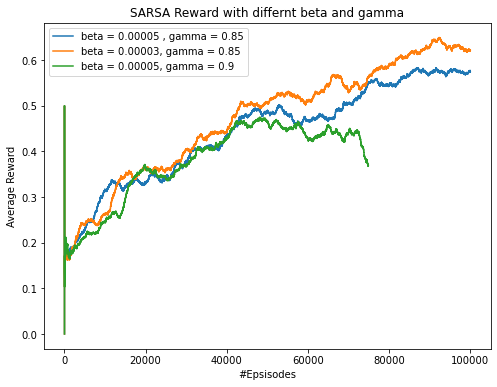

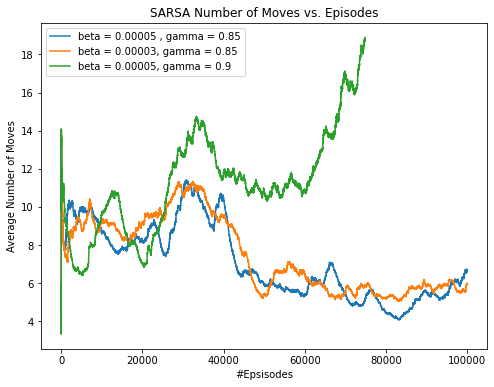

In [10]:
%store -r R_save_S
%store -r R_save_SB
%store -r R_save_SG
%store -r N_moves_save_S
%store -r N_moves_save_SB
%store -r N_moves_save_SG

# Convert Saved Reward for SARSA (R_save_S) into Exponential moving average series 
df_R_S = pd.DataFrame(R_save_S).ewm(span=5000).mean()
# Convert Saved Reward with different beta into Exponential moving average series 
df_R_SB = pd.DataFrame(R_save_SB).ewm(span=5000).mean()
# Convert Saved Reward with different gamma into Exponential moving average series 
df_R_SG = pd.DataFrame(R_save_SG[:74870,0]).ewm(span=5000).mean()
fig, axs = plt.subplots(1,figsize=(8,6))
plt.plot(np.arange(0,N_episodes),df_R_S,label="beta = 0.00005 , gamma = 0.85")
plt.plot(np.arange(0,N_episodes),df_R_SB,label="beta = 0.00003, gamma = 0.85")
plt.plot(np.arange(0,74870),df_R_SG,label="beta = 0.00005, gamma = 0.9")
plt.title("SARSA Reward with differnt beta and gamma")
plt.xlabel("#Epsisodes")
plt.ylabel("Average Reward")
plt.legend()


# Convert Saved Number of moves for SARSA (N_moves_save_S) into Exponential moving average series 
df_N_Moves_S = pd.DataFrame(N_moves_save_S).ewm(span=5000).mean()
# Convert Saved Number of moves with different beta into Exponential moving average series 
df_N_Moves_SB = pd.DataFrame(N_moves_save_SB).ewm(span=5000).mean()
# Convert Saved Number of moves with different gamma into Exponential moving average series 
df_N_Moves_SG = pd.DataFrame(N_moves_save_SG[:74870,0]).ewm(span=5000).mean()
fig, axs = plt.subplots(1,figsize=(8,6))
plt.plot(np.arange(0,N_episodes),df_N_Moves_S,label="beta = 0.00005 , gamma = 0.85")
plt.plot(np.arange(0,N_episodes),df_N_Moves_SB,label="beta = 0.00003, gamma = 0.85")
plt.plot(np.arange(0,74870),df_N_Moves_SG,label="beta = 0.00005, gamma = 0.9")
plt.title("SARSA Number of Moves vs. Episodes")
plt.xlabel("#Epsisodes")
plt.ylabel("Average Number of Moves")
plt.legend()

TASK 5: TRAIN AGENT WITH Q LEARNING

In [ ]:
# Prepare parameter for Q learning
W1_Q = np.copy(W1)
W2_Q = np.copy(W2)
b1_Q = np.copy(b1)
b2_Q = np.copy(b2)
R_save_Q  = np.copy(R_save)
N_moves_save_Q = np.copy(N_moves_save)

# Reset the seed = 1 to get the exact same result
seed = 1

# TRAINING LOOP FOR Q-Learning
for n in range(N_episodes):
    if(n%5000==0): print(n)
    # Calculate decaying epsilong for every episode
    epsilon_f = epsilon_0 / (1 + beta * n)   
    Done=0                            
    # Counter for the number of actions made in the episode      
    i = 1                             
    # Initialize the game
    S,X,allowed_a=env.Initialise_game()
    
    while Done==0:                           
        Q,x1 = Qvalues(X, W1_Q, W2_Q, b1_Q, b2_Q)
        # Choose the action based on Q values
        seed +=1 
        a_agent = EpsilonGreedy_Policy(Q,epsilon_f,allowed_a,seed)  
        # Take the action                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        if Done==1:
            # If finished, update the weight without the decaying factor for future Q value (because there is no next step)
            delta=R-Q[a_agent]

            delta_b2 = delta
            delta_W2 = delta*x1
            delta_b1 = delta*W2_Q[:,a_agent]*(x1>0)
            delta_W1=np.outer(X,delta_b1)

            # Update Weights and Biases through back propagation
            W2_Q[:,a_agent]=W2_Q[:,a_agent]+eta*delta_W2
            b2_Q[a_agent]=b2_Q[a_agent]+eta*delta_b2
            W1_Q=W1_Q+eta*delta_W1
            b1_Q=b1_Q+eta*delta_b1

            R_save_Q[n]=np.copy(R)
            N_moves_save_Q[n]=np.copy(i)
            break

        # Find Next Q values based on the next state
        Q_next,_ = Qvalues(X_next,W1_Q,W2_Q,b1_Q,b2_Q) 
        # Take into consideration of the discounted maximum future Q value 
        delta=R+gamma*np.max(Q_next)-Q[a_agent]
        
        delta_b2 = delta
        delta_W2 = delta*x1
        delta_b1 = delta*W2_Q[:,a_agent]*(x1>0)
        delta_W1=np.outer(X,delta_b1)
        
        # Updating Weights and biases
        W2_Q[:,a_agent]=W2_Q[:,a_agent]+eta*delta_W2
        b2_Q[a_agent]=b2_Q[a_agent]+eta*delta_b2
        W1_Q=W1_Q+eta*delta_W1
        b1_Q=b1_Q+eta*delta_b1 
            
        # Update the next state, etc.  
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        # Update the counter of moves
        i += 1  

In [6]:
# Store variables for Q_learning
%store W1_Q
%store b1_Q
%store W2_Q
%store b2_Q
%store R_save_Q
%store N_moves_save_Q

Stored 'W1_Q' (ndarray)
Stored 'b1_Q' (ndarray)
Stored 'W2_Q' (ndarray)
Stored 'b2_Q' (ndarray)
Stored 'R_save_Q' (ndarray)
Stored 'N_moves_save_Q' (ndarray)


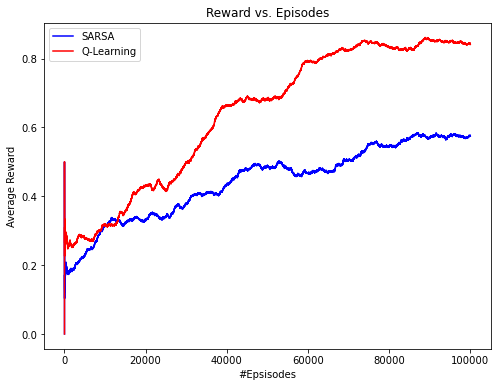

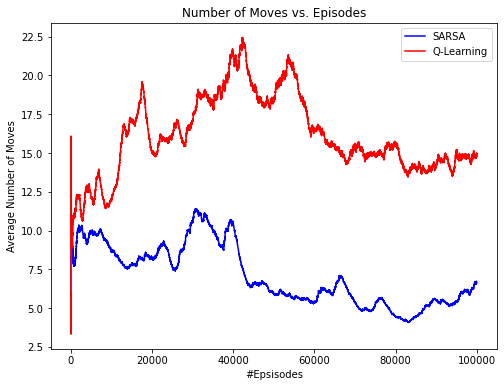

In [16]:
%store -r R_save_S
%store -r N_moves_save_S
%store -r R_save_Q
%store -r N_moves_save_Q

# Convert Saved Reward for SARSA (R_save_S) into Exponential moving average series 
df_R_S = pd.DataFrame(R_save_S).ewm(span=5000).mean()
# Convert Saved Reward for Q Learning (R_save_Q) into Exponential moving average series 
df_R_Q = pd.DataFrame(R_save_Q).ewm(span=5000).mean()
fig, axs = plt.subplots(1,figsize=(8,6))
plt.plot(np.arange(0,N_episodes),df_R_S,'b',label="SARSA")
plt.plot(np.arange(0,N_episodes),df_R_Q,'r',label="Q-Learning")
plt.title("Reward vs. Episodes")
plt.xlabel("#Epsisodes")
plt.ylabel("Average Reward")
plt.legend()


# Convert Saved Number of moves for SARSA (N_moves_save_S) into Exponential moving average series 
df_N_Moves_S = pd.DataFrame(N_moves_save_S).ewm(span=5000).mean()
# Convert Saved Number of moves for Q-Learning (N_moves_save_Q) into Exponential moving average series 
df_N_Moves_Q = pd.DataFrame(N_moves_save_Q).ewm(span=5000).mean()
fig, axs = plt.subplots(1,figsize=(8,6))
plt.plot(np.arange(0,N_episodes),df_N_Moves_S,"b", label="SARSA")
plt.plot(np.arange(0,N_episodes),df_N_Moves_Q,"r",label = "Q-Learning")
plt.title("Number of Moves vs. Episodes")
plt.xlabel("#Epsisodes")
plt.ylabel("Average Number of Moves")
plt.legend()
